# Best set selection performance (Figure 7 - Figure 8)  


In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Sketch-experiments/best_set_selection

Mounted at /content/drive
/content/drive/MyDrive/Sketch-experiments/best_set_selection


In [3]:
%run -i framework.py
%run -i exp.py
%matplotlib inline

In [4]:
from scipy.integrate import quad

def Pareto_exp_max(k, a):

    """
    Numerically evaluate expected maximum of k iid Pareto random variables with shape a and scale 1, i.e.,
    1 + ∫₁^∞ [1 - (1 - x^{-a})^k] dx for given values of k > 0 and a > 0.
    """

    if k <= 0 or a <= 0:
        raise ValueError("Both k and a must be positive.")

    # Define the integrand
    def integrand(x):
        val = 1 - (1 - x**(-a))**k
        return val

    # Evaluate the improper integral from 1 to ∞
    result, error = quad(integrand, 1, np.inf, limit=100, epsabs=1e-10)

    return result + 1

In [5]:
# fixed parameters
n = 50
n_sample = 10000
n_sets = 10
c = 0.1
#c = 0.05

In [6]:
objs = ['max', 'CES-2', 'square_root']
distributions = ["Exponential", "Pareto-scale-1.5"]
#distributions = ["Pareto-mean-1.0", "Pareto-mean-10.0"]
#distributions = ["Pareto-scale_eq_shape", "Pareto-scale_eq_invshape"]
ksize = np.arange(1,6)

### Best set selection performance compared to test score benchmark (Figure 8)


In [ ]:
def create_output_opt():
    column_labels_raw = ['obj', 'distribution', 'eps', 'k',
                         'test_number', 'ratio_T', 'ratio_Q']
    df_raw = pd.DataFrame(columns=column_labels_raw)
    df_raw.to_csv('res_opt.csv', index=False)

In [ ]:
create_output_opt()

In [ ]:
def run_optimization(n, k, eps, n_sample, distribution, obj, n_sets, run_test_scores = True):
    ### parameter set for different distributions
    if distribution == "Exponential":
      mean_values = np.linspace(0.1, 1.0, n)
      params = mean_values
    elif distribution[:13] == 'Pareto-scale-':
      m = float(distribution[13:])
      shapes = np.linspace(1.1, 3, n)
      scales = m * np.ones(n)
      params = np.concatenate((shapes, scales))
    elif distribution[:12] == 'Pareto-mean-':
      m = float(distribution[12:])
      shapes = np.linspace(1.1, 3, n)
      scales = m * (1 - 1/shapes)
      params = np.concatenate((shapes, scales))
    elif distribution == 'Pareto-scale_eq_invshape':
      shapes = np.linspace(1.1, 3, n)
      scales = 1/shapes
      params = np.concatenate((shapes, scales))
    elif distribution == 'Pareto-scale_eq_shape':
      shapes = np.linspace(1.1, 3, n)
      scales = shapes
      params = np.concatenate((shapes, scales))
    elif distribution[:29] == 'Pareto-fixed_test_score_at_k-':
      m = float(distribution[29:])
      shapes = np.linspace(1.1, 3, n)
      emax = np.array([Pareto_exp_max(k, shapes[i]) for i in range(n)])
      scales = m/emax
      params = np.concatenate((shapes, scales))


    df = pd.read_csv('./res_opt.csv')
    ### best set selection using sketch or test score method
    for j in range(n_sets):
        samples = get_sampleP(n, n_sample, distribution, params)
        S = greedy_select(samples, k=k, obj=obj)

        test_samples = get_sampleP(n, n_sample, distribution, params)
        u_S = f_value(S, test_samples, obj)
        samples_discrete = get_sampleQ(n, eps, params, n_sample, distribution)
        Sq = greedy_select(samples_discrete, k=k, obj=obj)
        u_Sq = f_value(Sq, test_samples, obj)
        u_St = 0
        if run_test_scores:
          test_score_samples = get_sampleP(n, n_sample, distribution, params)
          test_scores = compute_test_scores(n, k, n_sample, test_score_samples, obj)
          St = greedy_select_scores(test_scores, k=k, obj=obj)

          u_St = f_value(St, test_samples, obj)

        df = pd.concat([df, pd.DataFrame([{'obj': obj, 'distribution': distribution,
                        'eps': eps, 'k': k, 'test_number': j+1, 'ratio_T': u_St/u_S,
                        'ratio_Q': u_Sq/u_S}])], ignore_index=True)

    df.to_csv('res_opt.csv', index=False)

In [ ]:
c = 0.99
for k in ksize: ## k-size
    print(f"Now processing {k}")
    for obj in objs:
        run_optimization(n, k, c/k, n_sample, distributions[0], obj, n_sets)
        run_optimization(n, k, c/k, n_sample, distributions[1], obj, n_sets)

Now processing 1


/tmp/ipython-input-3467375369.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{'obj': obj, 'distribution': distribution,


Now processing 2
Now processing 3
Now processing 4
Now processing 5


In [ ]:
### Plotting utility for Figure 8
def bar_plot(objs):
    df = pd.read_csv('./res_opt.csv')

    for i, d in enumerate(distributions):

        fig, ax = plt.subplots(figsize=(6.4, 4.8))
        current = df[(df['distribution'] == d)]
        x_axis = np.arange(len(objs))

        # Calculate median and quantiles (25% and 75%)
        TS_stats = current.groupby(['obj'])['ratio_T'].agg([
            ('median', 'median'),
            ('q25', lambda x: np.quantile(x, 0.25)),
            ('q75', lambda x: np.quantile(x, 0.75))
        ])
        EB_stats = current.groupby(['obj'])['ratio_Q'].agg([
            ('median', 'median'),
            ('q25', lambda x: np.quantile(x, 0.25)),
            ('q75', lambda x: np.quantile(x, 0.75))
        ])

        # Compute error bars (distance from median to quantiles)
        TS_lower_err = TS_stats['median'] - TS_stats['q25']  # distance from median to 25th percentile
        TS_upper_err = TS_stats['q75'] - TS_stats['median']   # distance from median to 75th percentile
        EB_lower_err = EB_stats['median'] - EB_stats['q25']  # distance from median to 25th percentile
        EB_upper_err = EB_stats['q75'] - EB_stats['median']  # distance from median to 75th percentile

        # Plot with median and IQR error bars
        ax.bar(
            x_axis - 0.15, TS_stats['median'],
            yerr=[TS_lower_err, TS_upper_err],  # [lower, upper] errors
            capsize=5, width=0.3, label='Test Score', alpha=0.5
        )
        ax.bar(
            x_axis + 0.15, EB_stats['median'],
            yerr=[EB_lower_err, EB_upper_err],  # [lower, upper] errors
            capsize=5, width=0.3, label='Our method', alpha=0.5
        )

        # Add legends, grid, and labels
        ax.legend(fontsize=14, loc='upper left')
        ax.grid()
        ax.set_xticks(x_axis)
        ax.set_xticklabels(objs, fontsize=15)
        ax.set_xlabel("objectives", fontsize=15)
        ax.set_ylabel(r"$\hat{u}(S_v)\, /\, \hat{u}(S_u)$", fontsize=15)
        ax.set_ylim((0, 1.5))



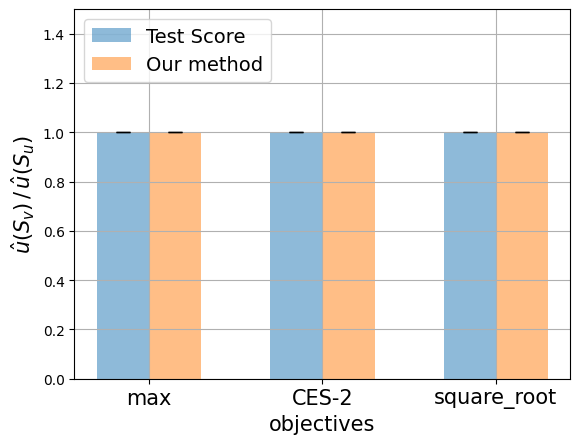

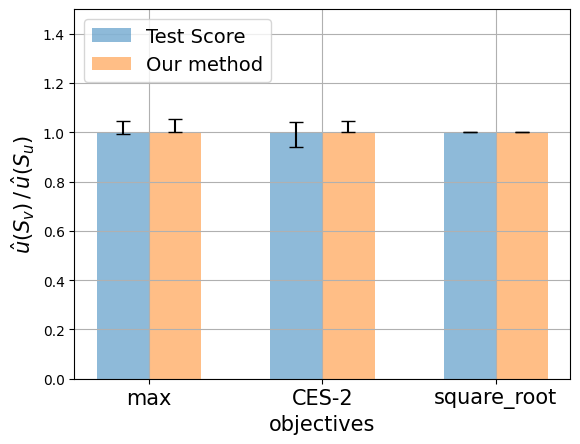

In [ ]:
bar_plot(objs)

### Dependency on $\epsilon$ (Figure 7)

In [ ]:
objs = ['max', 'CES-2', 'square_root']
#distributions = ["Exponential", "Pareto-scale-1.5"] # toggle Pareto scale
distributions = ["Pareto-scale_eq_shape", "Pareto-scale_eq_invshape"]
# fixed parameters
n = 50
n_sample = 500
n_sets = 50
c = np.round(np.logspace(-1,0.96,10),4)

In [ ]:
create_output_opt()

In [ ]:
for k in range(1,11):
  print(f"Now processing {k}")
  eps = [e for e in c / k if e<1]
  for e in eps:
    for obj in objs:
      run_optimization(n, k, e, n_sample, distributions[0], obj, n_sets, test_scores=False)
      # toggle distributions
      #run_optimization(n, k, e, n_sample, distributions[1], obj, n_sets, test_scores=False)

Now processing 1
Now processing 2
Now processing 3
Now processing 4
Now processing 5
Now processing 6
Now processing 7


In [ ]:
### Plotting utility for Figure 7
def box_plot_eps(df, distribution, is_log):
    fig, axes = plt.subplots(1, 3, figsize = (6.4*3, 4.8))
    flierprops = dict(marker='o', markeredgecolor='lightgrey', zorder=1)

    for i, obj in enumerate(objs):
      current = df[(df['distribution'] == distribution) & (df['obj'] == obj)].copy()

      current['c'] = np.round(current['k'] * current['eps'], 4)

      # Get unique c values sorted
      c_vals = np.array(sorted(current['c'].unique()))
      data_by_c = [current.loc[current['c'] == c_val, 'ratio_Q'] for c_val in c_vals]

      # Make sure log scale is set before computing widths
      if is_log == 1:
        axes[i].set_xscale('log')

      # Fixed width in axis fraction (e.g., 3% of total axis width)
      width_frac = 0.1

      # Convert that fraction into actual data widths at each c
      widths = []

      for c_val in c_vals:
        # centre in axis coords
        centre_disp = axes[i].transData.transform((c_val, 0))  # (pixels_x, pixels_y)
        left_disp = (centre_disp[0] - axes[i].get_window_extent().width * width_frac / 2, centre_disp[1])
        right_disp = (centre_disp[0] + axes[i].get_window_extent().width * width_frac / 2, centre_disp[1])

        # Convert back to data coords
        left_data = axes[i].transData.inverted().transform(left_disp)[0]
        right_data = axes[i].transData.inverted().transform(right_disp)[0]

        widths.append(right_data - left_data)

      # Draw boxplots with computed widths
      axes[i].boxplot(
        data_by_c,
        positions=c_vals,
        widths=widths,
        flierprops=flierprops,
        boxprops=dict(zorder=2),
        whiskerprops=dict(zorder=2),
        capprops=dict(zorder=2),
        medianprops=dict(zorder=3)
      )

      axes[i].grid()
      axes[i].set_title(obj, fontsize=16)
      axes[i].set_xlabel(r"$\epsilon \cdot k$", fontsize=16)
      axes[i].set_ylabel(r"$\hat{u}(S_v)\, /\, \hat{u}(S_u)$", fontsize=16)
      axes[i].set_xticks([1e-1, 1, 1e1])
      axes[i].set_xticklabels([1e-1, 1, 1e1])
      axes[i].set_ylim((0, 2))
      axes[i].set_xlim((1e-1-0.02, 1e1 + 2))


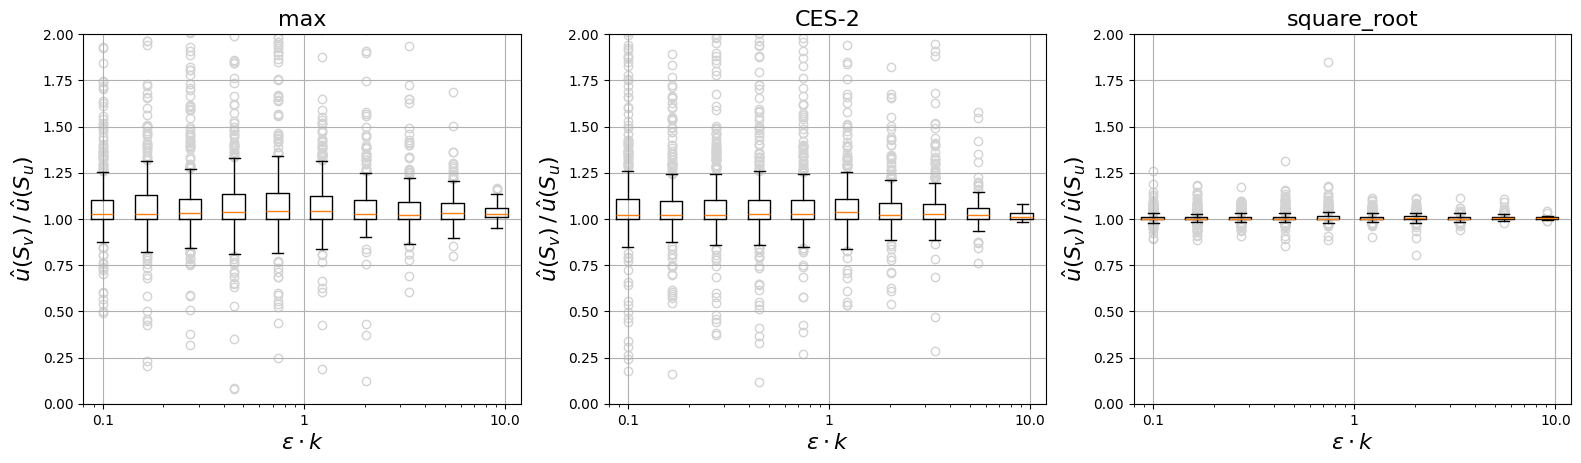

In [ ]:
df = pd.read_csv('./res_opt.csv')
box_plot_eps(df, 'Pareto-scale-1.5', 1)

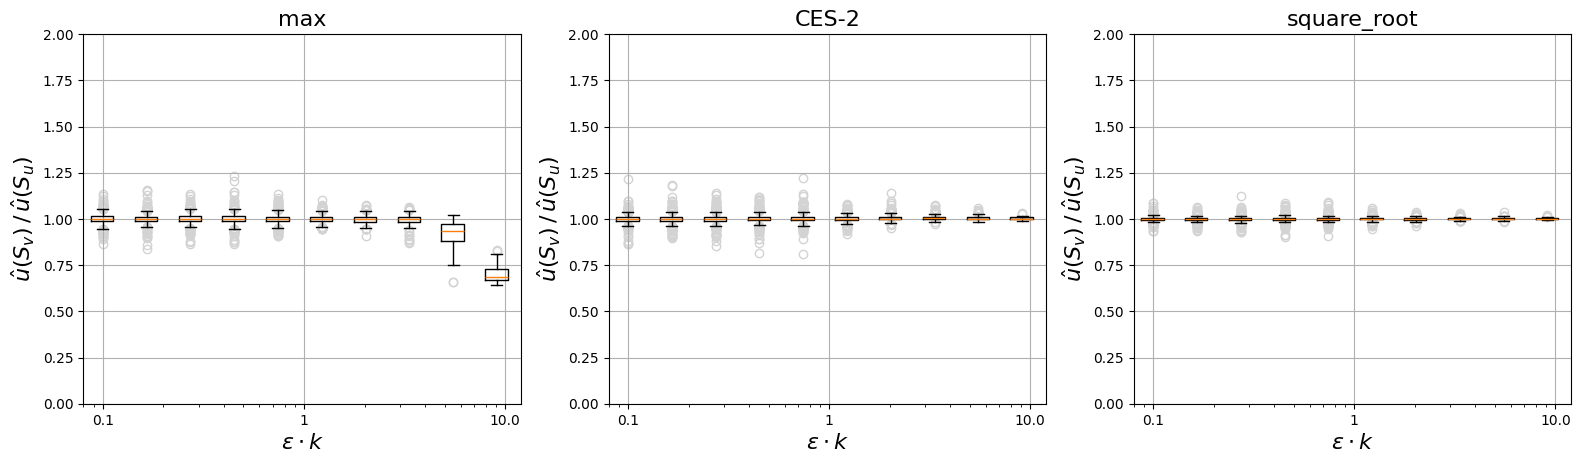

In [ ]:
df = pd.read_csv('./res_opt.csv')
box_plot_eps(df, 'Exponential', 1)